## Test notebook for Data Management Acceptance Test Campaign 1
This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T91: Verify implementation of Fringe Correction Frame

Verify that the DMS can produce an fringe-correction frame calibration product.
Verify that the DMS can determine the effectiveness of the fringe-correction frame and determine how often it should be updated.

In [1]:
from lsst.daf.butler import Butler

import matplotlib.pyplot as plt
import numpy as np
import os
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.obs.lsst as obs_lsst

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

#### Instantiate the Butler pointing to some HSC data:

In [2]:
repo = '/sdf/group/rubin/repo/main'
collection = 'HSC/runs/RC2/w_2022_28/DM-35609'
butler = Butler(repo, collections=collection)

#### Select a DataId for a single visit

Note: selected a y-band image since the test is specific to fringing.

In [3]:
dataId = {'instrument': 'HSC', 'detector': 42, 'visit': 1880, 'exposure': 1880}

In [4]:
raw = butler.get('raw', dataId=dataId)
fringe = butler.get('fringe', dataId=dataId)

#### Set up plotting defaults:

In [11]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Plot the fringe correction image:

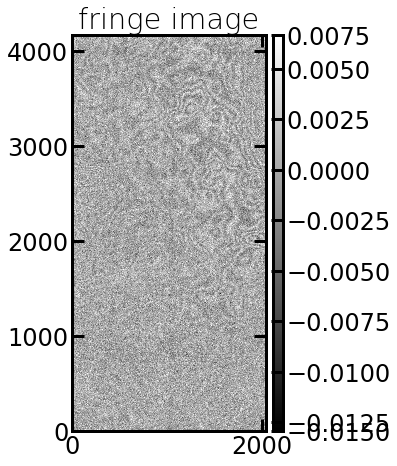

In [12]:
fig, ax = plt.subplots(1, 1)

display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(fringe.image)
plt.title("fringe image")

plt.tight_layout()
plt.show()

In [7]:
import lsst.pipe.base as pipeBase

fringe_struct = pipeBase.Struct(
    fringes = fringe,
)

That looks like a well-formed image, and clearly shows signs of fringing (i.e., the "swirls" that are prominent at upper right).

#### Configure the IsrTask with most corrections disabled.

Note that the `.run` method of `IsrTask` requires the detector number and a camera object to be passed.

In [8]:
isr_config = IsrTask.ConfigClass()
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doOverscan=False
isr_config.doBias=False
isr_config.doFringe=True
isr_config.doDefect=False
isr_config.doLinearize=False
isr = IsrTask(config=isr_config)
result = isr.run(raw, fringes=fringe_struct,
                 detectorNum=raw.detector.getId(),
                 camera=obs_lsst.LsstCamImSim.getCamera()
                )

No rough magnitude zero point defined for filter HSC-Y.


#### Examine the statistical properties of the raw and fringe-corrected image:

In [9]:
print('  image                     median     stddev    (of image pixel values)')
print('raw:                     ', np.nanmedian(raw.image.array), np.nanstd(raw.image.array))
print('after fringe correction: ', np.nanmedian(result.outputExposure.image.array), np.nanstd(result.outputExposure.image.array))

  image                     median     stddev    (of image pixel values)
raw:                      17078.0 3836.131470952384
after fringe correction:  17108.0 765.4047


#### Display the raw image before fringe correction and after:

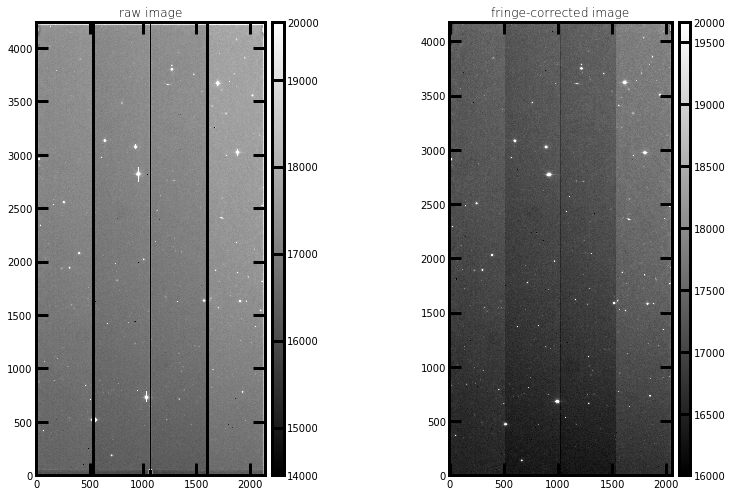

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(raw.image)
plt.title("raw image")

plt.sca(ax[1])
display0.scale("linear", "zscale")
display0.mtv(result.outputExposure.image)
plt.title("fringe-corrected image")

plt.tight_layout()
plt.show()

The fringe-corrected image has slightly different image statistics, and appears different when displayed. Therefore the fringe correction must have had the desired effect.